# Reduced Wannier functions and disentanglement

In [1]:
from pythtb import Mesh, Wannier, WFArray
from pythtb.models import haldane
import numpy as np

## Haldane model supercell construction

We begin by constructing the Haldane model in the topological phase, in which case the non-zero Chern number of the occupied bands enforces a topological obstruction to constructing exponentially localized Wannier functions that respect the lattice symmetries.

In [2]:
# tight-binding parameters
delta = 1
t1 = 1
t2 = -0.4
prim_model = haldane(delta, t1, t2)

print(f"Chern number: {prim_model.chern():0.3f}")

Chern number: 1.000


To circumvent the obstruction, we use the procedure of constructing "reduced Wannier" functions that are localized in a smaller subspace of the original Hilbert space. Since the occupied space is one-dimensional, there exists no subspace. This is why we must construct a supercell, folding the bands back into the first Brillouin zone, to obtain more occupied bands to choose from. Here we will use a 2x2 supercell, which will give us 4 occupied bands to work with.

In [3]:
n_super_cell = 2
model = prim_model.make_supercell([[n_super_cell, 0], [0, n_super_cell]])
model.report(show=True, short=True)

----------------------------------------
       Tight-binding model report       
----------------------------------------
r-space dimension           = 2
k-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 8
number of electronic states = 8



We construct the `WFArray` and diagonalize the model on a _semi-full_ k-mesh. It is important that the mesh not include the endpoints $k_i=1$, which correspond to the boundaries of the Brillouin zone. The Fourier transform requires a well-defined periodicity, which is disrupted by including these points. Therefore, we will use a k-mesh that spans the interior of the Brillouin zone, avoiding the boundaries. This is the default behavior of `Mesh.build_grid`. To specify that the k-mesh is periodic, with the topology of a torus, we can use the `Mesh.loop_axis` function, specifying the mesh axis and k-component that is wrapped.

In [4]:
nks = 20, 20 # number of k points along each dimension
mesh = Mesh(dim_k=2, axis_types=['k', 'k'])
mesh.build_grid(shape=nks)
mesh.loop_axis(0, 0)
mesh.loop_axis(1, 1)
print(mesh)

Mesh Summary
Type: grid
Dimensionality: 2 k-dim(s) + 0 λ-dim(s)
Number of mesh points: 400
Full shape: (20, 20, 2)
k-shape: (20, 20)
λ-shape: ()
k-axes: [0, 1]
λ-axes: []
Axis names: [k_0, k_1]
Endpoints included on axis: [◦, ◦]   (• yes, ◦ no/unknown)
Is a torus in k-space (all k-axes wrap): yes
Periodic axes: (axis 0 winds component 0), (axis 1 winds component 1)
Closed axes: None


Now we pass this mesh to the `WFArray` constructor and solve the mesh.

In [5]:
wfa = WFArray(model, mesh)
wfa.solve_mesh()

We know that Wannierizing the full set of 4 occupied bands is obstructed by the topology of the band structure. We can try the next best thing and Wannierize a 3-dimensional subspace. To do this, we will choose a set of three trial wavefunctions centered on 3 of the low energy orbitals, where we would expect the localized Wannier functions of the trivial occupied bands to be located

In [6]:
n_orb = model.norb # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)

low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers
high_E_sites = np.arange(1, n_orb, 2)  # high-energy sites defined to be indexed by odd numbers

omit_site = 6  # omitting one of the low energy sites
sites = list(np.setdiff1d(low_E_sites, [omit_site])) 
tf_list = [ [(orb, 1)] for orb in sites]  # trial wavefunctions in form of [(orbital index, weight)]

n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)]]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


## Optimal Alignment

Next, we initialize the `Wannier` object with the `TBModel` and `WFArray` objects. We initialize the Bloch-like states with `optimal_alignment` function which aligns the trial wavefunctions with the target bands specified by `band_idxs`.

In [7]:
WF = Wannier(model, wfa)

WF.optimal_alignment(tf_list, band_idxs=list(range(n_occ)))

Setting tilde states...


This already gives us a set of Wannier functions that are exponentially localized, showing that this is a trivial subsapce of the obstructed manifold.

In [8]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.27158
w_1 --> 0.27158
w_2 --> 0.27158
Centers:
w_0 --> [0.50229 0.29   ]
w_1 --> [1.      1.15205]
w_2 --> [1.49771 0.29   ]
Omega_I = 0.7388768356161961
Omega_D = 0.017518022898579618
Omega_OD = 0.0583525960781058


## Disentanglement

We can make these states even more localized with subspace selectio via the disentanglement procedure. This picks the subspace of the 4-band manfiold that minimizes the gauge-independent spread.

In [9]:
WF.disentangle(iter_num=2000, tol=1e-10, verbose=True, tf_speedup=True)

Initial Omega_I: 0.7388768356161614
0: Omega_i = 0.7351102822316992
1: Omega_i = 0.7318615809377473
2: Omega_i = 0.7289907618915638
3: Omega_i = 0.7264332823495082
4: Omega_i = 0.7241190471644706
5: Omega_i = 0.7220105343082207
6: Omega_i = 0.7200712940393514
7: Omega_i = 0.7182765759759342
8: Omega_i = 0.7165988236631265
9: Omega_i = 0.7150297932876285
10: Omega_i = 0.7135496885860831
11: Omega_i = 0.712153162568016
12: Omega_i = 0.7108250932777701
13: Omega_i = 0.7095559143917748
14: Omega_i = 0.7083451263293316
15: Omega_i = 0.70718367080295
16: Omega_i = 0.7060715431360489
17: Omega_i = 0.705001759185401
18: Omega_i = 0.7039620766543719
19: Omega_i = 0.7029635097668686
20: Omega_i = 0.7019946842269715
21: Omega_i = 0.7010596367920925
22: Omega_i = 0.7001503834895895
23: Omega_i = 0.6992684696349426
24: Omega_i = 0.6984124792851306
25: Omega_i = 0.6975793480967387
26: Omega_i = 0.6967671848184556
27: Omega_i = 0.695975474779779
28: Omega_i = 0.6952130423980482
29: Omega_i = 0.694459

## Maximal localization

To obtain maximally localized Wannier functions, we follow this with another projection to initialize a smooth gauge, then maximal localization.
- Note we must pass the flag `tilde=True` to indicate we are projecting the trial wavefunctions onto the tilde states and not the energy eigenstates

In [10]:
WF.optimal_alignment(use_tilde=True)

Setting tilde states...


In [11]:
WF.max_localize(eps=1e-3, iter_num=2000, tol=1e-10, grad_min=1e-12, verbose=True)

0 Omega_til = 0.04657130293939262, Grad mag: 1.9043553726463045e-05
1 Omega_til = 0.04648764375635928, Grad mag: 1.901131161706374e-05
2 Omega_til = 0.046406777573719624, Grad mag: 1.8978943824061037e-05
3 Omega_til = 0.0463285677221843, Grad mag: 1.8946459101250138e-05
4 Omega_til = 0.046252887702487505, Grad mag: 1.891386569372144e-05
5 Omega_til = 0.046179620086508374, Grad mag: 1.8881170852788552e-05
6 Omega_til = 0.04610865557617809, Grad mag: 1.8848381123756032e-05
7 Omega_til = 0.04603989219165191, Grad mag: 1.8815502741878755e-05
8 Omega_til = 0.04597323456741313, Grad mag: 1.8782541336097087e-05
9 Omega_til = 0.045908593338247414, Grad mag: 1.8749502109134652e-05
10 Omega_til = 0.04584588460101138, Grad mag: 1.8716390089287534e-05
11 Omega_til = 0.04578502944033098, Grad mag: 1.8683209775427542e-05
12 Omega_til = 0.045725953508922446, Grad mag: 1.8649965650376414e-05
13 Omega_til = 0.04566858665560144, Grad mag: 1.8616661786603947e-05
14 Omega_til = 0.04561286259222598, Grad m

In [12]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.23366
w_1 --> 0.23366
w_2 --> 0.23366
Centers:
w_0 --> [0.48286 0.27878]
w_1 --> [1.      1.17449]
w_2 --> [1.51714 0.27878]
Omega_I = 0.657840831889132
Omega_D = 0.0068725247373129725
Omega_OD = 0.03625306496884003


Now the spreads have been minimized, and the Wannier functions are maximally localized. To help validate that the Wannier functions are indeed exponentially localized, we can plot the decay of each Wannier function's weight away from its center with `plot_decay`. This will plot the absolute value of each Wannier function as a function of distance from its center on a logarithmic scale.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_0(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

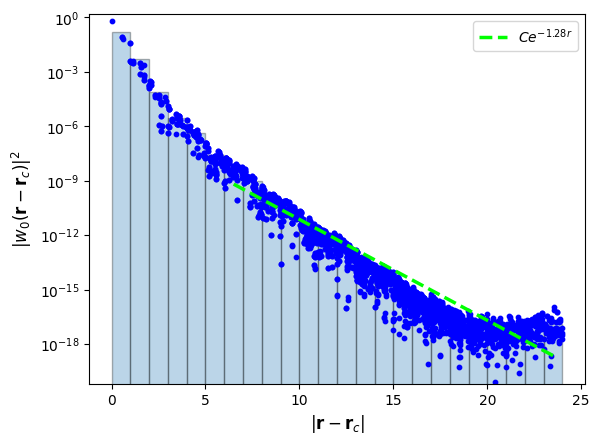

In [13]:
WF.plot_decay(0)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

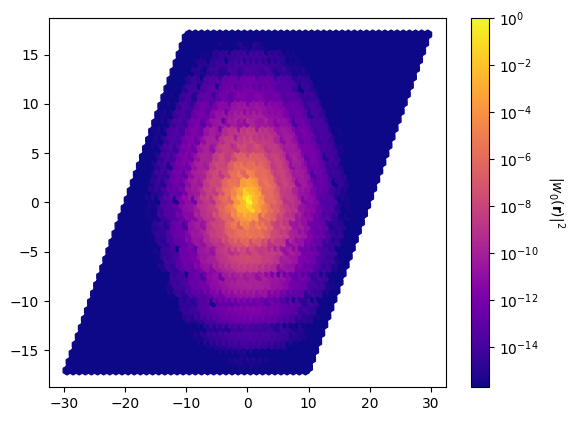

In [14]:
WF.plot_density(0)

Note that we have effectively broken the primitive translational symmetry of the underlying lattice by choosing a subset of trial wavefunctions on three out of the four low energy sites in the supercell. We can see their positions using `plot_centers`

(<Figure size 640x480 with 1 Axes>, <Axes: >)

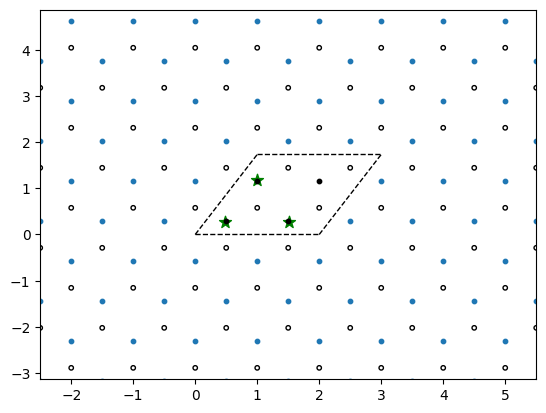

In [15]:
WF.plot_centers()

## Wannier interpolation

We can view the Wannier interpolated bands by calling `plot_interp_bands`. We specify a set of high-symmetry k-points that defines the one-dimensional path along which the bands are plotted. 

In [16]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')

In [17]:
n_interp = 501
interp_energies = WF.interp_bands(k_path, n_interp=n_interp, ret_eigvecs=False)

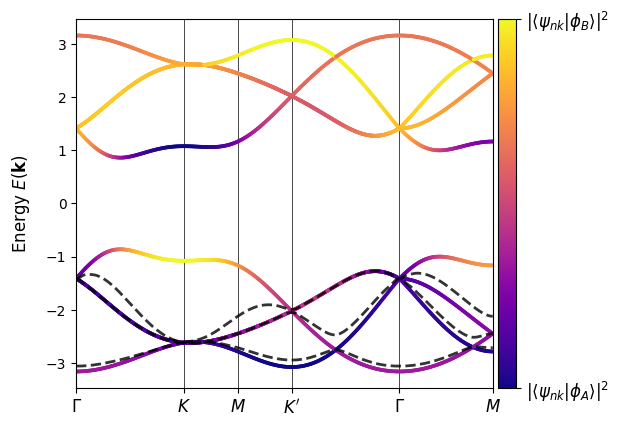

In [18]:
fig, ax = model.plot_bands(k_path, nk=501, k_label=k_label, proj_orb_idx=high_E_sites, cmap='plasma')

(k_vec, k_dist, k_node) = model.k_path(k_path, nk=n_interp, report=False)
ax.plot(k_dist, interp_energies, ls='--', c='k', lw=2, zorder=5, alpha=0.8)